In [1]:
from scipy.io import loadmat
from torch.utils.data import Dataset
from torch import nn
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from vqvae import VQVAE

In [2]:

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [3]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

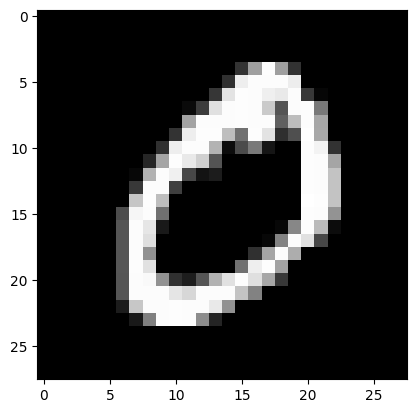

In [4]:
plt.imshow(mnist_data[0].reshape(28, 28), cmap="gray")

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)),
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2))  # Pad to 32x32
])

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
EPOCHS = 100
batch_size = 64
num_workers = 8
lr = 1e-3
beta = 0.25
n_embedding = 32
embedding_dim = 32

In [9]:
import wandb
wandb.login()

run =  wandb.init(
    project="vqvae_mnist",
    # entity="mnist_diffusion",
    name=f"n_embedding_{n_embedding}_embedding_dim_{embedding_dim}",
    config={
        "epochs": EPOCHS,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "lr": lr,
        "beta": beta,
        "n_embedding":n_embedding,
        "embedding_dim": embedding_dim,
    }
)

wandb: Currently logged in as: debugzwang (debugzwang-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
model = VQVAE(input_dim=1, dim=embedding_dim, n_embedding=n_embedding).to(device)


In [11]:
def loss_function(x, recon_x, ze, zq, beta=0.25):
    l_reconstruct = nn.functional.mse_loss(x, recon_x)
    l_embedding = nn.functional.mse_loss(ze.detach(), zq)
    l_commitment = beta * nn.functional.mse_loss(ze, zq.detach())
    return l_reconstruct +  l_commitment + l_embedding, l_reconstruct.item(), l_commitment.item(), l_embedding.item()


def train(
        model: VQVAE,
        optimizer: torch.optim.Optimizer,
        epochs: int,
        device: str,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        beta: float = 0.25,
):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.eval()
        val_loss = 0
        val_rec_loss = 0
        val_commit_loss = 0
        val_embed_loss = 0
        usage_accumulator = torch.zeros(model.vq_embedding.num_embeddings, device=device)

        with torch.no_grad():
            for index, (imgs, labels) in enumerate(val_dataloader):
                imgs = imgs.to(device)
                recon_x, ze, zq, usage_count = model(imgs, is_train=False)
                loss, rec_loss, commit_loss, embed_loss = loss_function(imgs, recon_x,ze, zq, beta)    
                val_loss += loss.item()
                val_rec_loss += rec_loss
                val_commit_loss += commit_loss
                val_embed_loss += embed_loss
                usage_accumulator += usage_count
        avg_usage = usage_accumulator / len(val_dataloader)
        model.train(True)
        training_loss = 0
        training_rec_loss = 0
        training_commit_loss = 0
        training_embed_loss = 0
        for index, (imgs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            imgs = imgs.to(device)
            recon_x, ze, zq = model(imgs, is_train=True)
            loss, rec_loss, commit_loss, embed_loss = loss_function(imgs, recon_x,ze, zq, beta)    
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            training_rec_loss += rec_loss
            training_commit_loss += commit_loss
            training_embed_loss += embed_loss
        # 创建一个表格，其中每行代表一个 embedding
        table = wandb.Table(columns=["Embedding Index", "Usage Percentage"])
        avg_usage_list = avg_usage.cpu().numpy().tolist()
        for idx, usage in enumerate(avg_usage_list):
            table.add_data(idx, usage)
        log_data = {
            "epoch": epoch,
            "training_loss": training_loss / len(train_dataloader),
            "training_rec_loss": training_rec_loss / len(train_dataloader),
            "training_commit_loss": training_commit_loss / len(train_dataloader),
            "training_embed_loss": training_embed_loss / len(train_dataloader),
            "val_loss": val_loss / len(val_dataloader),
            "val_rec_loss": val_rec_loss / len(val_dataloader),
            "val_commit_loss": val_commit_loss / len(val_dataloader),
            "val_embed_loss": val_embed_loss / len(val_dataloader),
            "embedding usage data": table,
        }
        if epoch % 5 == 0:
            plt.figure(figsize=(12, 8))
            x = np.arange(len(avg_usage.cpu().numpy()))
            plt.bar(x, avg_usage.cpu().numpy())
            embedding_usage_image = wandb.Image(plt)  # Save the image for logging
            plt.close()
        # Add the image only if it's generated
        if embedding_usage_image:
            log_data["embedding_usage"] = embedding_usage_image

        # Log everything at once
        wandb.log(log_data)
        

In [12]:
from torch.utils.data import random_split

# Assuming mnist_data and mnist_label are already defined
dataset = MNISTDataset(mnist_data, mnist_label, transform=transform)

# Define the lengths for training and validation sets
train_size = 50000
val_size = 10000
# train_size = 500
# val_size = 100
test_size = len(dataset) - train_size - val_size
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Now you can use train_dataset and val_dataset with DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [13]:
train(
    model=model,
    optimizer=torch.optim.Adam(params=model.parameters(), lr=lr),
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    beta=beta
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [14]:
torch.save(model.state_dict(), f"/mnt/d/data/mnist_model/vqvae_lr_{lr}_nembedding_{n_embedding}_embedding_dim_{embedding_dim}_beta_{beta}.pth")